In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
from collections import defaultdict
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [ ]:
# # filtered set
# df_reviews = pd.read_json('google reviews/filter_all_t.json', lines=True)

# df_train = pd.DataFrame(df_reviews.iloc[0]['train'])
# df_val = pd.DataFrame(df_reviews.iloc[0]['val'])
# df_test = pd.DataFrame(df_reviews.iloc[0]['test'])

# # combine all data so we can shuffle it and resplit
# df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [3]:
# full set
df_all = pd.read_json('google_reviews/image_review_all.json', lines=True)

In [4]:
# we'll use a fraction of df_all
df_all = df_all.sample(frac=0.15, random_state=42)
df_all.shape

(223162, 5)

In [5]:
# split into training, validation, and test sets 80-10-10
df_train, df_test = train_test_split(df_all, test_size=.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=.5, random_state=42)

print(f"df_train shape: {df_train.shape}")
print(f"df_val shape: {df_val.shape}")
print(f"df_test shape: {df_test.shape}")

df_all.head(1)

df_train shape: (178529, 5)
df_val shape: (22316, 5)
df_test shape: (22317, 5)


,business_id,user_id,rating,review_text,pics
233603,6052e7fa88c7af3f893e781b,1.051930e+20,5,"Small casual location, classy white decor and ...",[{'id': 'AF1QipN44hEMrE8yn9FWONlzoeDqQEDkQMhjZ...


## Some Data Exploration

In [7]:
df_train.shape

(178529, 5)

In [8]:
df_train.columns

Index(['business_id', 'user_id', 'rating', 'review_text', 'pics'], dtype='object')

Text(0, 0.5, 'Number of Ratings')

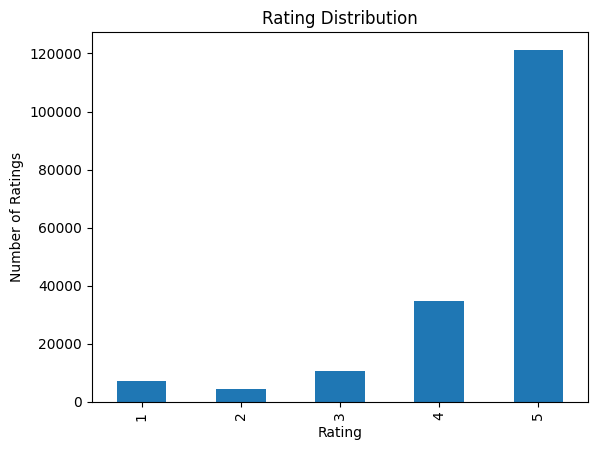

In [31]:
rating_distribution = df_train.groupby('rating').size()
rating_distribution.plot(title='Rating Distribution', kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

## number of reviews per User

In [32]:
user_review_counts = df_train.groupby('user_id').size()

# Convert to a DataFrame and reset the index
user_review_counts_df = user_review_counts.reset_index(name='review_count')

# Sort by review count in descending order
user_review_counts_sorted = user_review_counts_df.sort_values(by='review_count', ascending=False)

# Display the result
print(user_review_counts_sorted)

             user_id  review_count
655     1.000603e+20            19
12369   1.014550e+20            18
137692  1.163960e+20            15
114934  1.136639e+20            15
141876  1.168961e+20            13
...              ...           ...
54510   1.064884e+20             1
54509   1.064884e+20             1
54508   1.064884e+20             1
54507   1.064883e+20             1
154672  1.184467e+20             1

[154673 rows x 2 columns]


## Any users with no reviews?

In [10]:
zero_reviews_count = (user_review_counts_df['review_count'] == 0).sum()
zero_reviews_count

0

In [11]:
user_review_counts = df_train.groupby('user_id').size().reset_index(name='review_count')

# Calculate the distribution of review counts
distribution = user_review_counts['review_count'].value_counts().reset_index()
distribution.columns = ['review_count', 'frequency']
distribution = distribution.sort_values(by='review_count')

# Display the distribution
print(distribution)

    review_count  frequency
0              1     138124
1              2      12308
2              3       2677
3              4        869
4              5        346
5              6        162
6              7         76
7              8         46
8              9         26
9             10         18
10            11          8
11            12          6
12            13          3
13            15          2
15            18          1
14            19          1


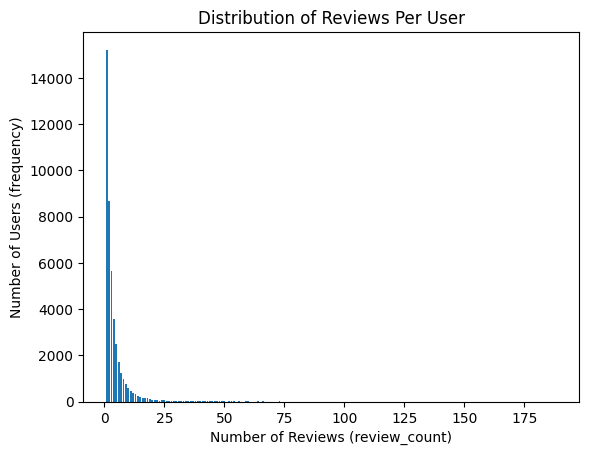

In [33]:
plt.bar(distribution['review_count'], distribution['frequency'])
plt.xlabel('Number of Reviews (review_count)')
plt.ylabel('Number of Users (frequency)')
plt.title('Distribution of Reviews Per User')
plt.show()

In [13]:
business_review_counts = df_train.groupby('business_id').size().reset_index(name='review_count')

# Calculate the distribution of review counts
distribution = business_review_counts['review_count'].value_counts().reset_index()
distribution.columns = ['review_count', 'frequency']
distribution = distribution.sort_values(by='review_count')

# Display the distribution
print(distribution)

    review_count  frequency
0              1      15220
1              2       8678
2              3       5643
3              4       3583
4              5       2472
..           ...        ...
80           138          1
79           142          1
86           149          1
99           150          1
97           188          1

[102 rows x 2 columns]


In [14]:
business_review_counts

,business_id,review_count
0,60401a5466e8bd764351f091,1
1,60401a7866e8bd764351f0b3,1
2,60401a959d447ef3f963f2a7,13
3,60401ab99d447ef3f963f2e4,3
4,60401af79d447ef3f963f30a,1
...,...,...
43986,60572c6df69c7b1178070364,2
43987,60572d189ffe343acca5fca5,4
43988,60572d22c4674474cff912db,1
43989,60572d91d2ad6b7a67e27fdf,7


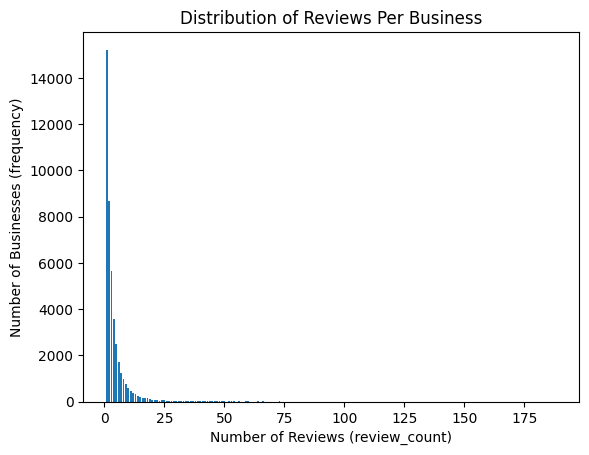

In [34]:
plt.bar(distribution['review_count'], distribution['frequency'])
plt.xlabel('Number of Reviews (review_count)')
plt.ylabel('Number of Businesses (frequency)')
plt.title('Distribution of Reviews Per Business')
plt.show()

## Any businesses with no reviews?

In [35]:
no_review_businesses_count = (business_review_counts['review_count'] == 0).sum()
no_review_businesses_count

0

### text review cloud

In [17]:
nltk.download('stopwords')

# Load the dataset (assuming a DataFrame `df` with a 'review_text' column)
reviews = df_train['review_text'].fillna('').str.lower()

# Combine all reviews into one string
text = ' '.join(reviews)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_text = ' '.join([word for word in text.split() if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


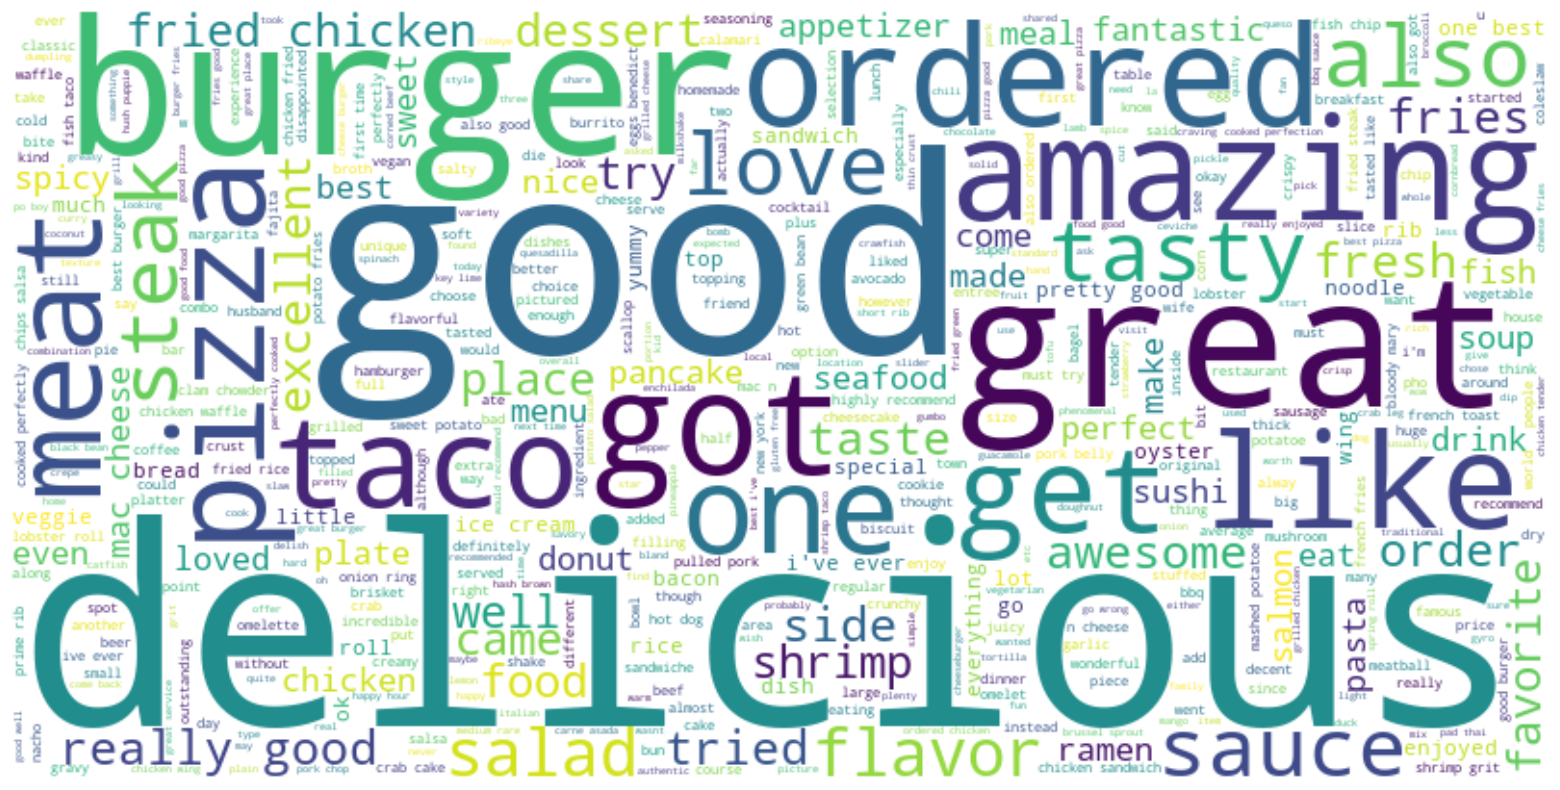

In [25]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='viridis',  # Optional: choose a color map
    max_words=500        # Optional: limit to the top 200 words
).generate(filtered_text)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Some stuff from lecture

In [18]:
punctuation = set(string.punctuation)

In [19]:
wordCount = defaultdict(int)

# Iterate over the rows of the DataFrame
for _, row in df_train.iterrows():
    # Access the review_text column
    review_text = row['review_text']
    
    # Remove punctuation and convert to lowercase
    r = ''.join([c for c in review_text.lower() if c not in punctuation])
    
    # Count words
    for w in r.split():
        wordCount[w] += 1

In [20]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [21]:
counts[:10]

[(382766, 'the'),
 (277879, 'and'),
 (172198, 'a'),
 (163786, 'was'),
 (136679, 'to'),
 (132174, 'i'),
 (101158, 'is'),
 (96451, 'food'),
 (91659, 'of'),
 (85918, 'it')]

In [22]:
len(wordCount)

119417

In [23]:
NW = 1000

words = [x[1] for x in counts[:NW]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [24]:
def feature(row):
    feat = [0] * len(words)
    review_text = row['review_text']
    r = ''.join([c for c in review_text.lower() if c not in punctuation])
    for w in r.split():
        if w in wordSet:
            feat[wordId[w]] += 1
    feat.append(1)  # Add offset term
    return feat

In [25]:
X_train = df_train.apply(feature, axis=1).tolist()
y = df_train['rating'].tolist()

In [26]:
ridge_mod = Ridge(1, fit_intercept = False)
ridge_mod.fit(X_train, y)

Ridge(alpha=1, fit_intercept=False)

In [27]:
theta = ridge_mod.coef_

In [28]:
weights = list(zip(theta, words + ['offset']))
weights.sort()

In [29]:
weights[:10]

[(-1.1485184447594952, 'worst'),
 (-0.9622288523343501, 'horrible'),
 (-0.8458303926931625, 'terrible'),
 (-0.7030139837648117, 'overpriced'),
 (-0.655806432273039, 'rude'),
 (-0.614654264467262, 'burnt'),
 (-0.5825773242653758, 'dirty'),
 (-0.5054271401905523, 'disappointing'),
 (-0.4606768219679676, 'slow'),
 (-0.45098838559707155, 'bland')]

In [30]:
weights[-11:]

[(0.21798127616441387, 'outstanding'),
 (0.21981486732645633, 'superb'),
 (0.22038199242307308, 'exceptional'),
 (0.22549092478899566, 'incredible'),
 (0.2275226644007198, 'best'),
 (0.2353185188467101, 'excellent'),
 (0.23890461523915052, 'awesome'),
 (0.2389213231145063, 'amazing'),
 (0.2550911495988474, 'reasonably'),
 (0.31836619312793313, 'disappoint'),
 (4.341465098002514, 'offset')]

## Baseline predictors

In [36]:
# 1. Global Average Predictor
global_average = df_train['rating'].mean()
y_test_global_pred = np.full(len(df_test), global_average)  # Predict the global average for all test examples
global_mse = mean_squared_error(df_test['rating'], y_test_global_pred)
print(f"Global Average Predictor MSE: {global_mse}")

# 2. Restaurant Average Predictor
# Compute average rating for each restaurant in the training set
restaurant_avg = df_train.groupby('business_id')['rating'].mean()

# Predict ratings using the restaurant average
y_test_restaurant_pred = df_test['business_id'].map(restaurant_avg).fillna(global_average)  # Use global average if restaurant not in training
restaurant_mse = mean_squared_error(df_test['rating'], y_test_restaurant_pred)
print(f"Restaurant Average Predictor MSE: {restaurant_mse}")

# 3. User Average Predictor
# Compute average rating given by each user in the training set
user_avg = df_train.groupby('user_id')['rating'].mean()

# Predict ratings using the user average
y_test_user_pred = df_test['user_id'].map(user_avg).fillna(global_average)  # Use global average if user not in training
user_mse = mean_squared_error(df_test['rating'], y_test_user_pred)
print(f"User Average Predictor MSE: {user_mse}")

Global Average Predictor MSE: 1.0001686692353864
Restaurant Average Predictor MSE: 1.159070595808638
User Average Predictor MSE: 1.0670659841535344


## Text Embeddings Model Testing

### Reviews represented by Bag of Words unigram word embeddings of top 1000 common words

In [37]:
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english')

In [38]:
X_train = vectorizer.fit_transform(df_train['review_text'])

In [39]:
X_val = vectorizer.transform(df_val['review_text'])
X_test = vectorizer.transform(df_test['review_text'])

In [40]:
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [41]:
alphas = [0.01, 0.1, 1, 10, 100]

In [42]:
# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

In [43]:
# Fit the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [44]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 100


In [45]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")

Validation MSE: 5.5350902027489814


In [46]:
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 5.579078672618012


### let's try bigrams now

In [47]:
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(2, 2))

# Fit the vectorizer on the training data (bigrams)
X_train = vectorizer.fit_transform(df_train['review_text'])

# Transform the validation and test sets using the same vectorizer
X_val = vectorizer.transform(df_val['review_text'])
X_test = vectorizer.transform(df_test['review_text'])

# Extract the target variable (ratings)
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [48]:
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test

# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

# Get the best model and hyperparameter
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [49]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")

Validation MSE: 8.072018879394067


In [50]:
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 7.977280548842434


### trigram testing

In [51]:
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(3, 3))

# Fit the vectorizer on the training data (trigrams)
X_train = vectorizer.fit_transform(df_train['review_text'])

# Transform the validation and test sets using the same vectorizer
X_val = vectorizer.transform(df_val['review_text'])
X_test = vectorizer.transform(df_test['review_text'])

# Extract the target variable (ratings)
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']


In [52]:
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test

# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [53]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")


Best alpha: 1


In [54]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")


Validation MSE: 14.660730015564804


In [55]:
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 14.610934384366447


### TF-IDF vector representation instead of Bag of Words

In [56]:
vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 1))  # Use unigrams

In [57]:
X_train = vectorizer.fit_transform(df_train['review_text'])

# Transform the validation and test sets using the same vectorizer
X_val = vectorizer.transform(df_val['review_text'])
X_test = vectorizer.transform(df_test['review_text'])

# Extract the target variable (ratings)
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [58]:
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test

# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [59]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 1


In [60]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")

Validation MSE: 1.706635323406076


In [61]:
# Optionally, evaluate on the test set for final performance
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 1.6742726141521063


### increasing number of vocabulary features size of 5000 with TF-IDF

In [62]:
vectorizer_tfidf_5000 = TfidfVectorizer(max_features=5000, lowercase=True, stop_words='english', ngram_range=(1, 1)) 

In [63]:
X_train = vectorizer_tfidf_5000.fit_transform(df_train['review_text'])

# Transform the validation and test sets using the same vectorizer
X_val = vectorizer_tfidf_5000.transform(df_val['review_text'])
X_test = vectorizer_tfidf_5000.transform(df_test['review_text'])

# Extract the target variable (ratings)
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [64]:
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test

# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [65]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 1


In [66]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")

Validation MSE: 1.6513163618706346


In [67]:
# Optionally, evaluate on the test set for final performance
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 1.6284295100496549


### Now let's try vocabulary size of 10,000 with TF IDF

In [68]:
vectorizer_tfidf_10000 = TfidfVectorizer(max_features=10000, lowercase=True, stop_words='english', ngram_range=(1, 1)) 

In [69]:
X_train = vectorizer_tfidf_10000.fit_transform(df_train['review_text'])

# Transform the validation and test sets using the same vectorizer
X_val = vectorizer_tfidf_10000.transform(df_val['review_text'])
X_test = vectorizer_tfidf_10000.transform(df_test['review_text'])

# Extract the target variable (ratings)
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [70]:
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test

# Use GridSearchCV to find the best alpha
ridge = Ridge(fit_intercept=False)  # No intercept as offset term is added in your feature function
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [71]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 1


In [72]:
ridge_best = grid_search.best_estimator_
y_val_pred = ridge_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {mse_val}")

Validation MSE: 1.6688787698770668


In [73]:
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 1.6514133929374724


### Looks like mse actually went up with increasing vocab size from 5000 to 10000

### Now let's try word2vec embeddings

In [74]:
# Train Word2Vec model on the training text
sentences = [review.split() for review in df_train['review_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [75]:
# Function to compute the average Word2Vec embedding for a document
def document_vector(doc, model):
    words = [word for word in doc.split() if word in model.wv]
    if len(words) == 0:  # Handle empty documents
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

In [76]:
# Create feature vectors for the training set
X_train = np.array([document_vector(doc, word2vec_model) for doc in df_train['review_text']])
y_train = df_train['rating']

# Create feature vectors for the validation and test sets
X_val = np.array([document_vector(doc, word2vec_model) for doc in df_val['review_text']])
y_val = df_val['rating']

X_test = np.array([document_vector(doc, word2vec_model) for doc in df_test['review_text']])
y_test = df_test['rating']

In [77]:
# Train Ridge Regression and Tune Hyperparameters on Validation Set
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train, y_train)
    
    # Predict on validation set and calculate MSE
    y_val_pred = ridge.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"Alpha: {alpha}, Validation MSE: {mse_val}")
    
    # Track best alpha and MSE
    if mse_val < best_mse:
        best_alpha = alpha
        best_mse = mse_val

print(f"Best alpha: {best_alpha}, Best Validation MSE: {best_mse}")

Alpha: 0.01, Validation MSE: 0.7203801201947555
Alpha: 0.1, Validation MSE: 0.720380063157097
Alpha: 1, Validation MSE: 0.7203794944364802
Alpha: 10, Validation MSE: 0.7203739712214184
Alpha: 100, Validation MSE: 0.7203336916465457
Best alpha: 100, Best Validation MSE: 0.7203336916465457


In [78]:
# Train the final model with the best alpha and evaluate on the test set
ridge_best = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_best.fit(X_train, y_train)
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 0.7185370166959497


### word2vec model works really well

### Now let's try GloVe word representation instead of word2Vec

In [79]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


In [80]:
# Path to GloVe file (update this to the correct path)
glove_file_path = 'glove.6B.100d.txt'  # For 100-dimensional embeddings
glove_embeddings = load_glove_embeddings(glove_file_path)

In [81]:
# Function to compute the average GloVe embedding for a document
def document_vector(doc, embeddings, vector_size=100):
    words = [word for word in doc.split() if word in embeddings]
    if len(words) == 0:  # Handle empty documents
        return np.zeros(vector_size)
    return np.mean([embeddings[word] for word in words], axis=0)

In [82]:
# Create feature vectors for the training set
X_train = np.array([document_vector(doc, glove_embeddings) for doc in df_train['review_text']])
y_train = df_train['rating']

# Create feature vectors for the validation and test sets
X_val = np.array([document_vector(doc, glove_embeddings) for doc in df_val['review_text']])
y_val = df_val['rating']

X_test = np.array([document_vector(doc, glove_embeddings) for doc in df_test['review_text']])
y_test = df_test['rating']

In [83]:
# Train Ridge Regression and Tune Hyperparameters on Validation Set
alphas = [0.01, 0.1, 1, 10, 100]  # Range of alpha values to test
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train, y_train)
    
    # Predict on validation set and calculate MSE
    y_val_pred = ridge.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"Alpha: {alpha}, Validation MSE: {mse_val}")
    
    # Track best alpha and MSE
    if mse_val < best_mse:
        best_alpha = alpha
        best_mse = mse_val

print(f"Best alpha: {best_alpha}, Best Validation MSE: {best_mse}")

Alpha: 0.01, Validation MSE: 0.8514592692612836
Alpha: 0.1, Validation MSE: 0.8514582297488977
Alpha: 1, Validation MSE: 0.8514479262474113
Alpha: 10, Validation MSE: 0.8513536018549599
Alpha: 100, Validation MSE: 0.8510022301428425
Best alpha: 100, Best Validation MSE: 0.8510022301428425


In [84]:
# Train the final model with the best alpha and evaluate on the test set
ridge_best = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_best.fit(X_train, y_train)
y_test_pred = ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 0.8466480985822313


### TFIDF with word2Vec

In [85]:
vectorizer_TFIDF_word2vec = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer_TFIDF_word2vec.fit_transform(df_train['review_text'])
X_val_tfidf = vectorizer_TFIDF_word2vec.transform(df_val['review_text'])
X_test_tfidf = vectorizer_TFIDF_word2vec.transform(df_test['review_text'])

In [86]:
sentences = [review.split() for review in df_train['review_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [87]:
# 3. Function to Compute Word2Vec Embeddings for Documents
def document_vector(doc, model, vector_size=100):
    words = [word for word in doc.split() if word in model.wv]
    if len(words) == 0:  # Handle empty documents
        return np.zeros(vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)


In [88]:
X_train_w2v = np.array([document_vector(doc, word2vec_model) for doc in df_train['review_text']])
X_val_w2v = np.array([document_vector(doc, word2vec_model) for doc in df_val['review_text']])
X_test_w2v = np.array([document_vector(doc, word2vec_model) for doc in df_test['review_text']])

# 4. Combine TF-IDF and Word2Vec Features
X_train_combined = np.hstack([X_train_tfidf.toarray(), X_train_w2v])
X_val_combined = np.hstack([X_val_tfidf.toarray(), X_val_w2v])
X_test_combined = np.hstack([X_test_tfidf.toarray(), X_test_w2v])

# Target Variable
y_train = df_train['rating']
y_val = df_val['rating']
y_test = df_test['rating']

In [89]:
# 5. Train Ridge Regression and Tune Hyperparameters
alphas = [0.01, 0.1, 1, 10, 100]
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train_combined, y_train)
    
    # Predict on validation set and calculate MSE
    y_val_pred = ridge.predict(X_val_combined)
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"Alpha: {alpha}, Validation MSE: {mse_val}")
    
    # Track best alpha and MSE
    if mse_val < best_mse:
        best_alpha = alpha
        best_mse = mse_val

print(f"Best alpha: {best_alpha}, Best Validation MSE: {best_mse}")

Alpha: 0.01, Validation MSE: 0.44947756301976916
Alpha: 0.1, Validation MSE: 0.44921719320095793
Alpha: 1, Validation MSE: 0.44756335330635494
Alpha: 10, Validation MSE: 0.4534852841840708
Alpha: 100, Validation MSE: 0.5324425087113956
Best alpha: 1, Best Validation MSE: 0.44756335330635494


In [90]:
# 6. Evaluate Final Model on Test Set
ridge_best = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_best.fit(X_train_combined, y_train)
y_test_pred = ridge_best.predict(X_test_combined)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 0.44728803119173666


### Using TF-IDF with cosine similarity

In [91]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(df_train['review_text'])
X_test_tfidf = vectorizer.transform(df_test['review_text'])

In [92]:
y_train = np.array(df_train['rating'])
y_test = np.array(df_test['rating'])

In [93]:
# 2. Cosine Similarity for Rating Prediction
def predict_rating(review_vector, X_train_tfidf, y_train, k=5):
    # Compute cosine similarity between the review and all training reviews
    similarities = cosine_similarity(review_vector, X_train_tfidf).flatten()
    
    # Get indices of the top-k most similar reviews
    top_k_indices = similarities.argsort()[-k:][::-1]
    
    # Get the ratings of the most similar reviews
    top_k_ratings = y_train[top_k_indices]
    top_k_similarities = similarities[top_k_indices]
    
    # Compute the weighted average rating
    if top_k_similarities.sum() == 0:
        return top_k_ratings.mean()  # Default to mean rating if no similarity
    weighted_rating = np.dot(top_k_ratings, top_k_similarities) / top_k_similarities.sum()
    return weighted_rating

In [94]:
# 3. Predict Ratings for the Test Set
y_test_pred = []
for i in range(X_test_tfidf.shape[0]):
    review_vector = X_test_tfidf[i]
    pred_rating = predict_rating(review_vector, X_train_tfidf, y_train, k=5)
    y_test_pred.append(pred_rating)

In [95]:
# Convert to numpy array
y_test_pred = np.array(y_test_pred)


In [96]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")

Test MSE: 0.7916307463747362
